# Import Library

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Import Dataset

In [ ]:
# kaggle datasets download -d dwikrisda/skin-problem-dataset

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre Processing Dataset

In [ ]:
# Path folder di Google Drive
folder_path = '/content/drive/My Drive/Coba'

# List semua file dalam folder
file_names = os.listdir(folder_path)
print(f"Files in folder: {file_names}")

Files in folder: ['Train', 'Test']


## Count total image in every folder after split

In [ ]:
def count_images_in_folder(folder_path):
    total_images = 0
    # Menghitung file gambar dalam folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
                total_images += 1
    return total_images

def count_images_in_train_test(train_folder, test_folder):
    # Daftar subfolder di dalam train dan test
    subfolders = [f.name for f in os.scandir(train_folder) if f.is_dir()]

    for subfolder in subfolders:
        train_subfolder_path = os.path.join(train_folder, subfolder)
        test_subfolder_path = os.path.join(test_folder, subfolder)

        # Menghitung gambar dalam folder train dan test
        train_images = count_images_in_folder(train_subfolder_path)
        test_images = count_images_in_folder(test_subfolder_path)

        print(f"Jumlah gambar di folder 'train/{subfolder}': {train_images}")
        print(f"Jumlah gambar di folder 'test/{subfolder}': {test_images}")

# Path ke folder 'train' dan 'test'
train_folder = '/content/drive/My Drive/Coba/Train'
test_folder = '/content/drive/My Drive/Coba/Test'

# Hitung jumlah gambar dalam train dan test
count_images_in_train_test(train_folder, test_folder)


Jumlah gambar di folder 'train/Milia': 98
Jumlah gambar di folder 'test/Milia': 78
Jumlah gambar di folder 'train/Bags': 65
Jumlah gambar di folder 'test/Bags': 50
Jumlah gambar di folder 'train/Bopeng': 95
Jumlah gambar di folder 'test/Bopeng': 73
Jumlah gambar di folder 'train/Bruntusan': 99
Jumlah gambar di folder 'test/Bruntusan': 79
Jumlah gambar di folder 'train/Redness': 53
Jumlah gambar di folder 'test/Redness': 43
Jumlah gambar di folder 'train/Acne': 96
Jumlah gambar di folder 'test/Acne': 72


## Generate Train dan Validasi Dataset

In [ ]:
# Path ke folder Train dan Test
train_dir = '/content/drive/My Drive/Coba/Train'
val_dir = '/content/drive/My Drive/Coba/Test'

# Generator untuk data Train
train_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  # Ukuran gambar yang di-resize
    batch_size=32,
    label_mode='categorical', # Multi-class classification
    color_mode="rgb",
)

# Generator untuk data Test
val_generator = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(256, 256),  # Ukuran gambar yang di-resize
    batch_size=32,
    label_mode='categorical',  # Multi-class classification
    color_mode="rgb",
)
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_generator
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (val_generator
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

Found 506 files belonging to 6 classes.
Found 395 files belonging to 6 classes.


# Modelling

## Create model layers

In [ ]:
def create_model():
    """Create the classifier model

    Returns:
        tf.keras.model.Sequential: CNN for multi-class classification
    """
    # Define the model
    model = tf.keras.models.Sequential([
        # Define an input layer
        tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
        # Rescale images
        tf.keras.layers.Rescaling(1./255),
        # First Conv2D layer with MaxPooling
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second Conv2D layer with MaxPooling
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second Conv2D layer with MaxPooling
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second Conv2D layer with MaxPooling
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second Conv2D layer with MaxPooling
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second Conv2D layer with MaxPooling
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Flatten the output and add dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),

        # Output layer with units equal to the number of classes (24 for this dataset)
        tf.keras.layers.Dense(6, activation='softmax')  # Softmax for multi-class classification
    ])



    return model

In [ ]:
model= create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## Compile Model

In [ ]:
# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss = 'categorical_crossentropy',
                  metrics = ["accuracy"])

## Model Summary

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,296,710 (12.58 MB)

 Trainable params: 3,296,710 (12.58 MB)

 Non-trainable params: 0 (0.00 B)

## Model Evaluation

In [ ]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 256, 256, 3)
Output shape: (None, 6)


In [ ]:
for images, labels in train_dataset_final.take(1):
	example_batch_images = images
	example_batch_labels = labels

try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 6)


## Callbacks

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=0):

        # Check if the accuracy is greater or equal to 0.98
        if logs['accuracy']>= 0.98:

            # Stop training once the above condition is met
            self.model.stop_training = True

            print("\nReached 98% accuracy so cancelling training!")

## Training Model

In [ ]:
# Train your model
history = model.fit(train_dataset_final,
                    epochs=500,
                    validation_data=validation_dataset_final, callbacks=[EarlyStoppingCallback()])

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 766ms/step - accuracy: 0.2145 - loss: 1.7911 - val_accuracy: 0.2835 - val_loss: 1.7759
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2055 - loss: 1.7703 - val_accuracy: 0.2278 - val_loss: 1.7569
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.2276 - loss: 1.7734 - val_accuracy: 0.2861 - val_loss: 1.7351
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.2236 - loss: 1.7329 - val_accuracy: 0.3544 - val_loss: 1.5991
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.3212 - loss: 1.5853 - val_accuracy: 0.3494 - val_loss: 1.4583
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3382 - loss: 1.4883 - val_accuracy: 0.3494 - val_loss: 1.4175
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3706 - loss: 1.4510 - val_accuracy: 0.3291 - val_loss: 1.4394
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.3383 - loss: 1.4523 - val_accuracy: 

## Plotting Accuracy and Loss

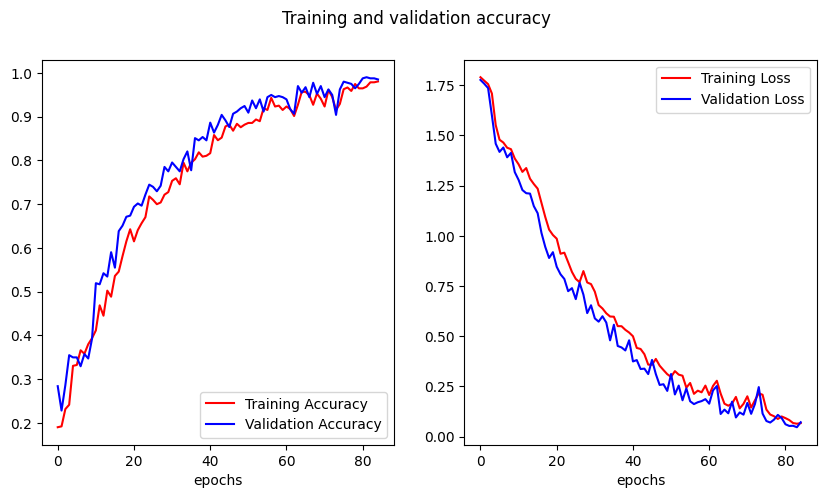

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
# # EXERCISE: Save the trained model as a Keras HDF5 file.

# saved_model_path = "./my_model.h5"

# # YOUR CODE HERE
# model.save(saved_model_path)

In [ ]:
# !tensorflowjs_converter --input_format=keras {saved_model_path} ./

2024-12-09 14:18:37.213581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733753917.236810   26798 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733753917.244427   26798 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# saved_model_path = "./my_model.h5"

# # Coba simpan ulang model
# try:
#     model.save(saved_model_path)
# except TypeError as e:
#     print("Error:", e)
#     print("Ensure there are no custom or unsupported objects in your model.")

## Test Model with other image

In [ ]:
# Create the widget and take care of the display
from ipywidgets import widgets
from io import BytesIO
import tensorflow as tf
import numpy as np

# Initialize the file upload widget
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

# Define a function to handle predictions
def file_predict(filename, file, out):
    """A function for creating the prediction and printing the output."""
    # Load and preprocess the image
    image = tf.keras.utils.load_img(file, target_size=(256, 256))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Replace 'model_with_aug' with your trained model
    prediction = model_with_aug.predict(image, verbose=0)[0]

    # Classes corresponding to the model output
    classes = ['Acne', 'Bags', 'Bopeng', 'Bruntusan', 'Milia', 'Redness']

    # Get the index of the highest probability
    max_index = np.argmax(prediction)
    max_prob = prediction[max_index]
    max_class = classes[max_index]

    # Display the prediction
    with out:
        print(f'\nModel output for {filename}:')
        print(f'  - Predicted class: {max_class} with probability {max_prob:.5f}')

# Define the file upload handler
def on_upload_change(change):
    """A function for getting files from the widget and running the prediction."""
    items = change['new']  # Access the newly uploaded files
    for filename, file_info in items.items():  # Loop through each uploaded file
        file_jpgdata = BytesIO(file_info['content'])
        file_predict(filename, file_jpgdata, out)

# Attach the observer to the uploader widget
uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()